In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import random
%matplotlib inline

In [2]:
def read_image(fname):
    return cv2.cvtColor(
        cv2.imread(fname),
        cv2.COLOR_BGR2RGB
    )

In [3]:
def load_test_images():
    images = []
    for name in ['test1.jpg', 'test2.jpg', 'test3.jpg',
                'test3.jpg', 'test4.jpg', 'test6.jpg']:
        images.append(read_image('test_images/' + name))
    return images

In [4]:
TEST_IMAGES = load_test_images()

In [5]:
def print_images(images, title=None):
    f, axs = plt.subplots(1, len(images), figsize=(20,20))
    if title:
        print(title)
        print('-' * len(title))
    for i, image in enumerate(images):
        axs[i].imshow(image)
    plt.show()

Test Images
-----------


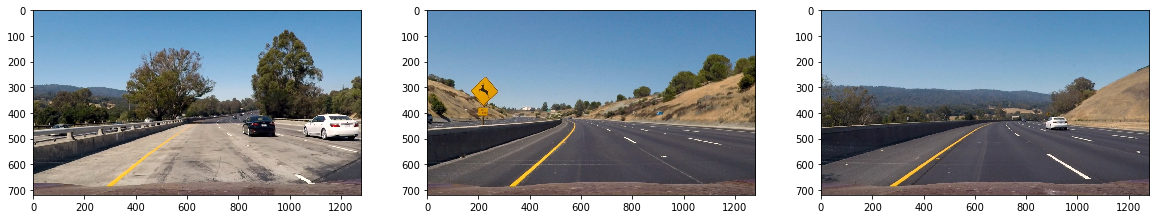

In [6]:
print_images(TEST_IMAGES[0:3], title='Test Images')

In [7]:
(H, W, D) = TEST_IMAGES[0].shape

In [8]:
print('Image Dimensions: ' + str(W) + ' x ' + str(H))

Image Dimensions: 1280 x 720


In [9]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

In [10]:
def print_random_boxes(images):
    random_boxes = [
        ((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
        ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

    drawn_images = [draw_boxes(image, random_boxes) for image in images]

    print_images(drawn_images, "Test Draw Boxes")

Test Draw Boxes
---------------


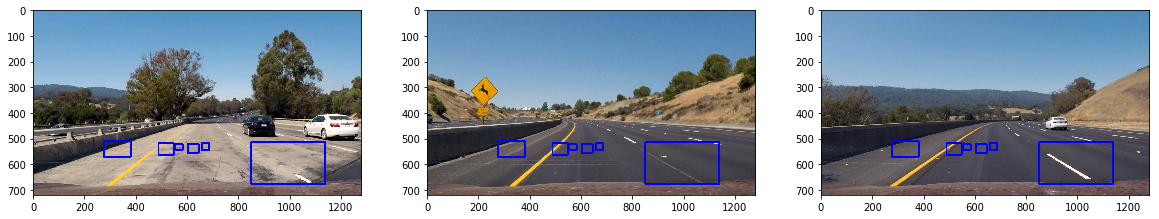

In [11]:
print_random_boxes(TEST_IMAGES[0:3])

In [12]:
def load_train_images():
    cars = []
    non_cars = []
    for image in glob.glob('train_images/vehicles/*/*'):
        cars.append(read_image(image))
    for image in glob.glob('train_images/non-vehicles/*/*'):
        non_cars.append(read_image(image))
    return cars, non_cars

In [13]:
CARS, NON_CARS = load_train_images()

Cars
----


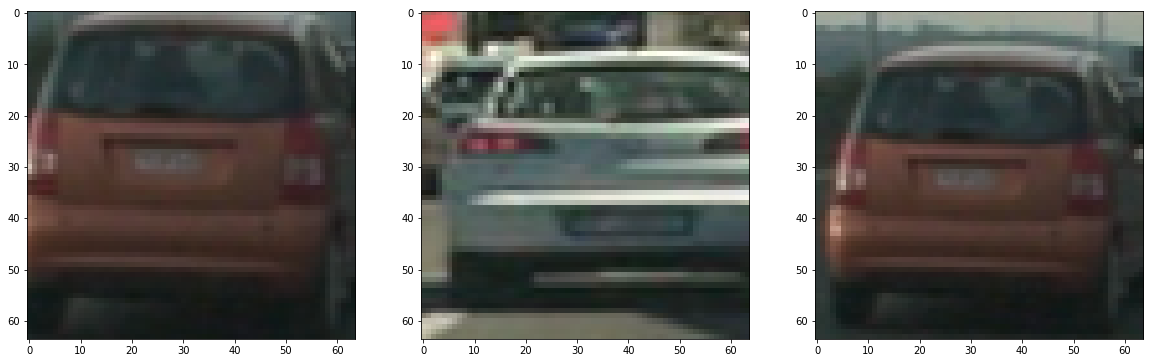

Non Cars
--------


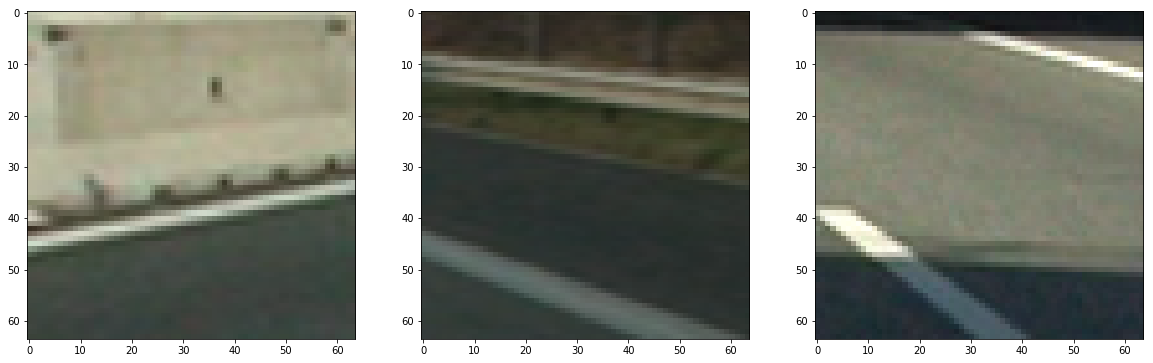

In [14]:
print_images(CARS[0:3], title='Cars')
print_images(NON_CARS[0:3], title='Non Cars')

In [15]:
NBINS = 64
BINS_RANGE = (0, 256)

def get_color_histogram(image, nbins=NBINS, bins_range=BINS_RANGE, vis=False):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.hstack((rhist[0], ghist[0], bhist[0]))
    
    if vis:
        # Generating bin centers
        bin_edges = rhist[1]

        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

        # Return the individual histograms, bin_centers and feature vector
        return rhist, ghist, bhist, bin_centers, hist_features
    
    return hist_features

In [16]:
def print_color_histogram(image, title=None):
    plt.subplots(1, 3, figsize=(20,4))
    
    rh, gh, bh, bincen, feature_vec = get_color_histogram(image, vis=True)

    if title:
        print(title)
        print('-' * len(title))

    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')

Car Color Histogram
-------------------


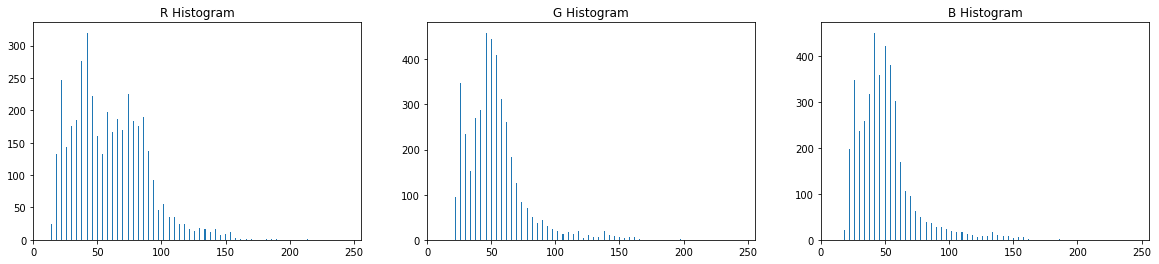

In [17]:
print_color_histogram(CARS[0], 'Car Color Histogram')

Non Car Color Histogram
-----------------------


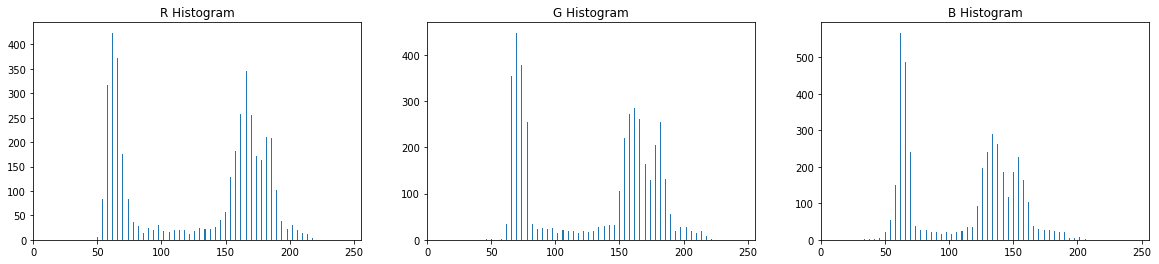

In [18]:
print_color_histogram(NON_CARS[0], 'Non Car Color Histogram')

In [19]:
COLOR_SPACE = 'YCrCb'
SPATIAL_SIZE = (32, 32)

def bin_spatial(img, color_space=COLOR_SPACE, size=SPATIAL_SIZE):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [20]:
def print_color_spaces(img, title = None):
    f, axs = plt.subplots(2, 3, figsize=(20, 10))
    color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
    
    if title:
        print(title)
        print('-' * len(title))

    for i, color_space in enumerate(color_spaces):
        ax = axs[int(i / 3)][i % 3]
        ax.plot(bin_spatial(img, color_space))
        ax.set_title(color_space, fontsize=20)
    f.tight_layout() 

Car Color Spaces
----------------


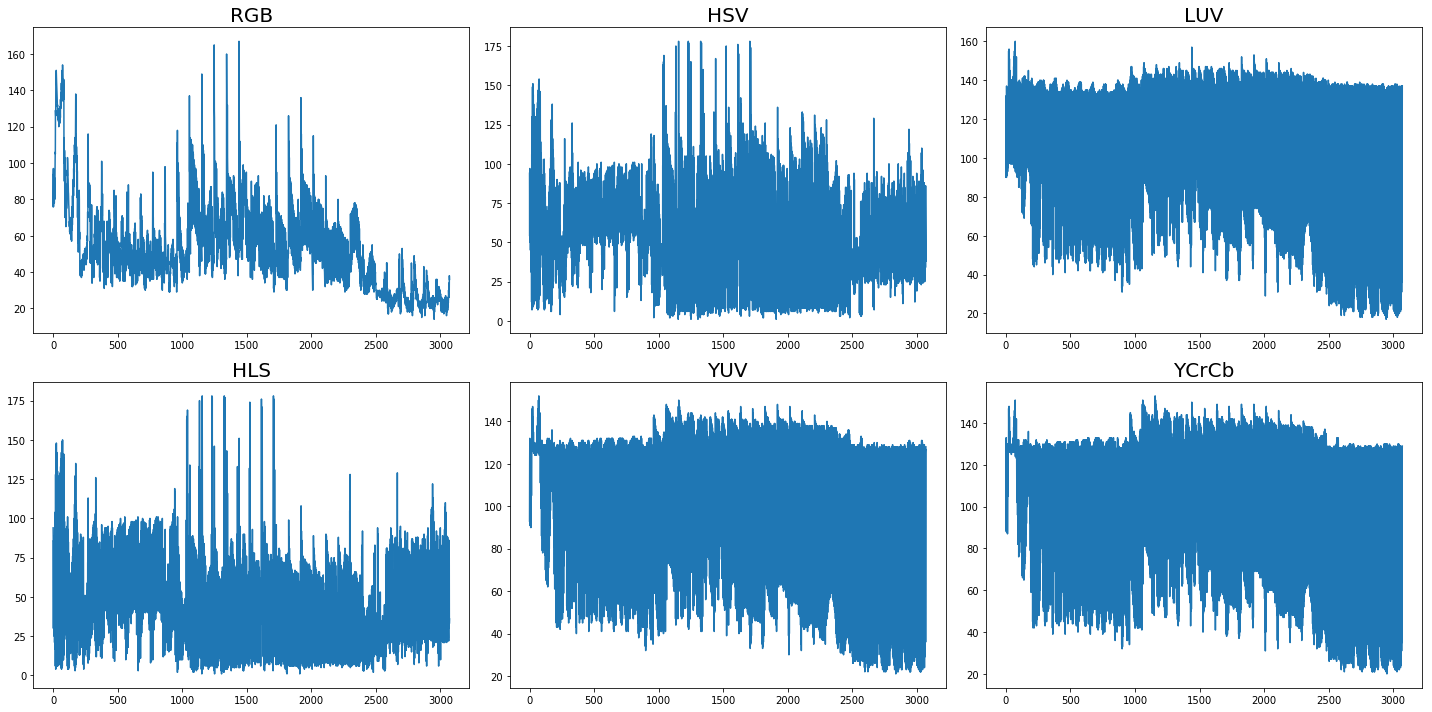

In [21]:
print_color_spaces(CARS[0], 'Car Color Spaces')

Non Car Color Spaces
--------------------


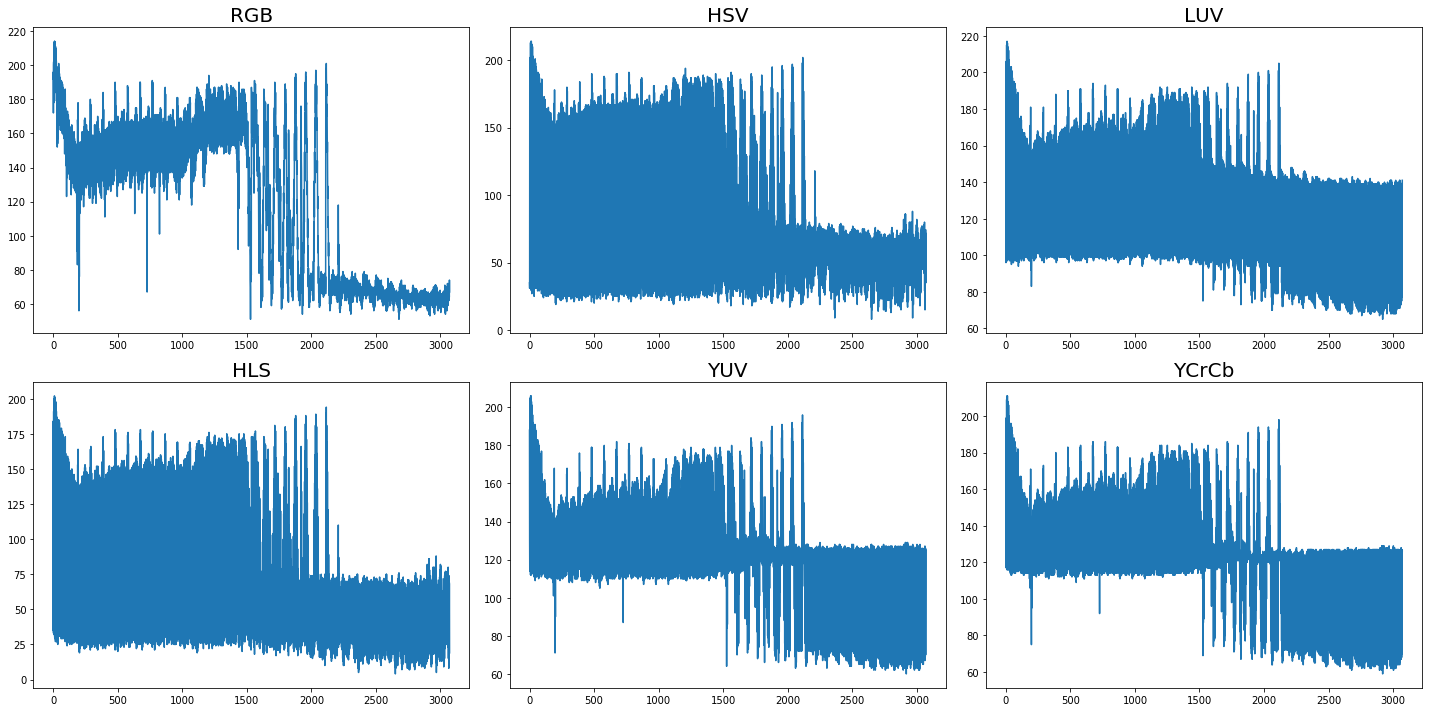

In [22]:
print_color_spaces(NON_CARS[0], 'Non Car Color Spaces')

In [23]:
ORIENT = 10
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2

from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(
    image, orient=ORIENT, pix_per_cell=PIX_PER_CELL,
    cell_per_block=CELL_PER_BLOCK, vis=False, feature_vec=True
):
    img = np.copy(image)
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
            visualise=True, feature_vector=False, block_norm="L2-Hys")
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
           cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
           visualise=False, feature_vector=feature_vec, block_norm="L2-Hys")
    return features

In [24]:
def print_hog_features(car, non_car):
    gray_car = cv2.cvtColor(car, cv2.COLOR_RGB2GRAY)

    car_features, car_hog = get_hog_features(
        gray_car, vis=True
    )
    
    gray_non_car = cv2.cvtColor(non_car, cv2.COLOR_RGB2GRAY)
    non_car_features, non_car_hog = get_hog_features(
        gray_non_car, vis=True
    )
    
    f, axs = plt.subplots(1, 4, figsize=(20,20))
    
    axs[0].imshow(car)
    axs[0].set_title('Car')
    
    axs[1].imshow(car_hog, cmap='gray')
    axs[1].set_title('Car HOG')
    
    axs[2].imshow(non_car)
    axs[2].set_title('Non Car')
    
    axs[3].imshow(non_car_hog, cmap='gray')
    axs[3].set_title('Non Car HOG')

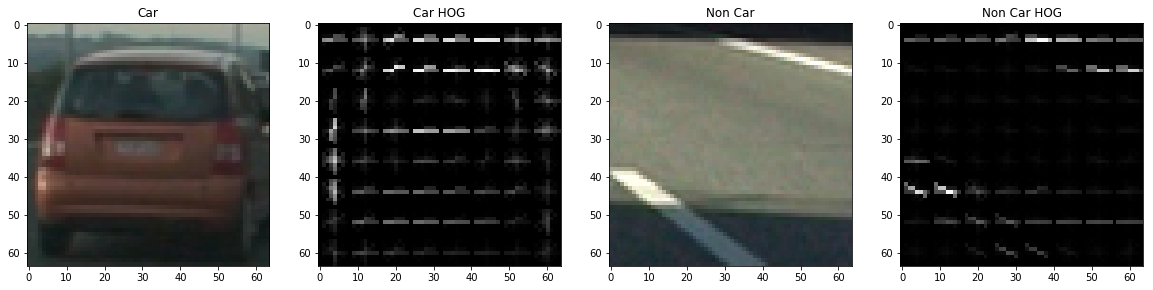

In [25]:
print_hog_features(CARS[2], NON_CARS[2])

In [29]:
def single_img_features(
    image, cspace=COLOR_SPACE, orient=ORIENT, pix_per_cell=PIX_PER_CELL,
    spatial_size=SPATIAL_SIZE, cell_per_block=CELL_PER_BLOCK,
    hist_bins=NBINS, hist_range=BINS_RANGE, hog_channels='ALL'
):
    # Read in each one by one
    # image = mpimg.imread(file)
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)   
            
    else: feature_image = np.copy(image)      
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size, color_space=cspace)
    # Apply color_hist() also with a color space option now
    hist_features = get_color_histogram(
        feature_image, nbins=hist_bins, bins_range=hist_range, vis=False
    )
    # Append the new feature vector to the features list
    if hog_channels == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(get_hog_features(
                feature_image[:,:,channel], orient, pix_per_cell,
                cell_per_block, vis=False, feature_vec=True
            ))
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        hog_features = get_hog_features( # feature_image[:,:]
            image[:,:], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True
        )
    return np.concatenate((spatial_features, hist_features, hog_features))

In [30]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(
    imgs, cspace=COLOR_SPACE, orient=ORIENT, pix_per_cell=PIX_PER_CELL,
    spatial_size=SPATIAL_SIZE, cell_per_block=CELL_PER_BLOCK,
    hist_bins=NBINS, hist_range=BINS_RANGE, hog_channels='ALL'
):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        features.append(single_img_features(
            image, cspace, orient, pix_per_cell, spatial_size,
            cell_per_block, hist_bins, hist_range, hog_channels
        ))
    # Return list of feature vectors
    return features

In [31]:
CAR_FEATURES     = extract_features(CARS)
NON_CAR_FEATURES = extract_features(NON_CARS)

In [32]:
from sklearn.preprocessing import StandardScaler

def get_scaled_features(car_features, notcar_features):
    # Create an array stack of feature vectors
    raw_X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(raw_X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(raw_X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    return raw_X, scaled_X, X_scaler, y

In [33]:
RAW_X, SCALED_X, X_SCALER, Y = get_scaled_features(CAR_FEATURES, NON_CAR_FEATURES)

In [34]:
def print_extracted_features(raw_X, scaled_X, car_images):
    car_ind = np.random.randint(0, len(car_images))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(car_images[car_ind])
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(raw_X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()

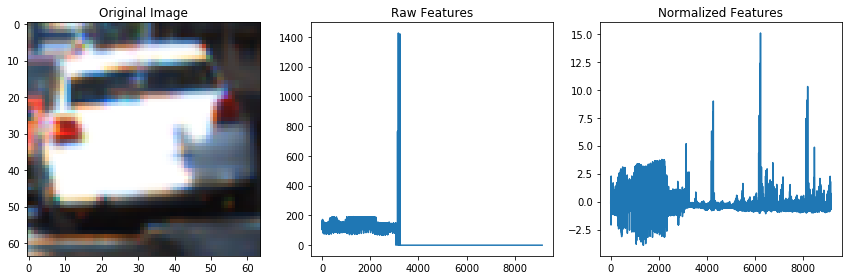

In [35]:
print_extracted_features(RAW_X, SCALED_X, CARS)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time

def train(X, y):
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # print('Using spatial binning of:', spatial, 'and', histbin, 'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc

In [37]:
SVC = train(SCALED_X, Y)

Feature vector length: 9144
6.3 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
My SVC predicts:  [ 0.  1.  1.  1.  0.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  0.  0.  1.  0.  1.]
0.00175 Seconds to predict 10 labels with SVC


In [39]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [61]:
def print_drawn_windows(windows, image):
    print('Windows: ' + str(len(windows)))
    plt.figure(figsize=(10,10))
    plt.imshow(
        draw_boxes(
            draw_boxes(image, windows, color=(0, 0, 0), thick=4),
            [random.choice(windows)],
            color=(0,0,255),
            thick=4
        )
    )

Windows: 82


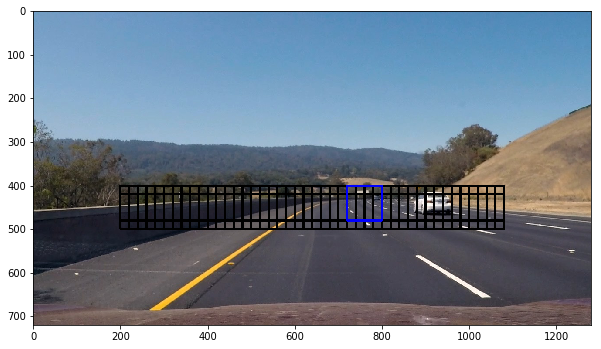

In [62]:
SMALL_WINDOWS = slide_window(
    TEST_IMAGES[0], xy_window=(80, 80), xy_overlap=(0.75, 0.75), x_start_stop=[200, W-200], y_start_stop=[400, 500]
)

print_drawn_windows(SMALL_WINDOWS, TEST_IMAGES[3])

Windows: 96


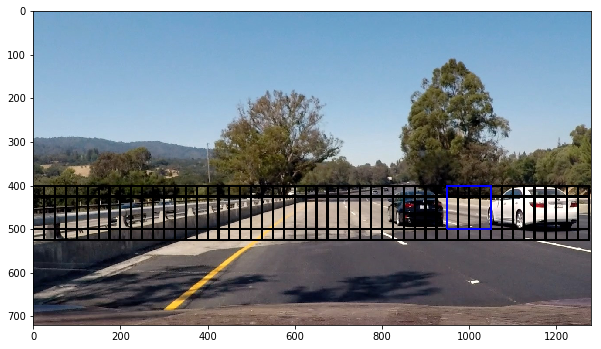

In [88]:
MEDIUM_WINDOWS = slide_window(
    TEST_IMAGES[0], xy_window=(100, 100), xy_overlap=(0.75, 0.75), y_start_stop=[400, 540]
)

print_drawn_windows(MEDIUM_WINDOWS, TEST_IMAGES[4])

Windows: 36


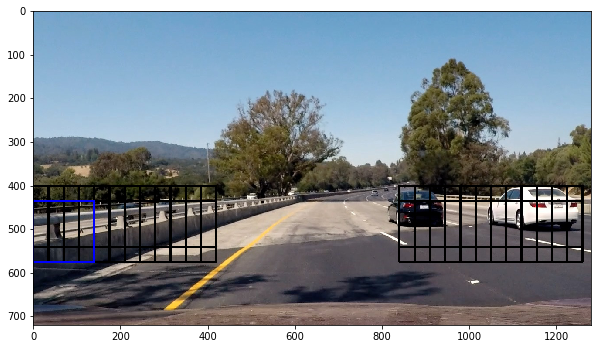

In [91]:
LARGE_WINDOWS = slide_window(
    TEST_IMAGES[0], xy_window=(140, 140), xy_overlap=(0.75, 0.75), x_start_stop=[0, 440], y_start_stop=[400, H-120]
) + slide_window(
    TEST_IMAGES[0], xy_window=(140, 140), xy_overlap=(0.75, 0.75), x_start_stop=[W-440, W], y_start_stop=[400, H-120]
)

print_drawn_windows(LARGE_WINDOWS, TEST_IMAGES[4])

In [92]:
INITIAL_WINDOWS = SMALL_WINDOWS + MEDIUM_WINDOWS + LARGE_WINDOWS

In [93]:
def search_windows(img, windows=INITIAL_WINDOWS, clf=SVC, scaler=X_SCALER):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

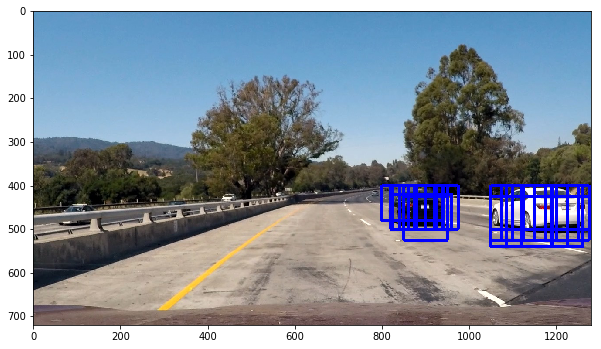

In [94]:
TEST_BOXES = search_windows(TEST_IMAGES[0])
plt.figure(figsize=(10,10))
plt.imshow(draw_boxes(TEST_IMAGES[0], TEST_BOXES))

In [95]:
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def get_fitted_boxes(image, box_list, threshold=2, vis=False):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    # Iterate through all detected cars
    draw_img = np.copy(image)
    boxes = []

    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        boxes.append(bbox)
        if vis:
            cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
    
    if vis:
        fig = plt.figure(figsize=(10,10))
        plt.subplot(121)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        plt.subplot(122)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        fig.tight_layout()
    
    return boxes

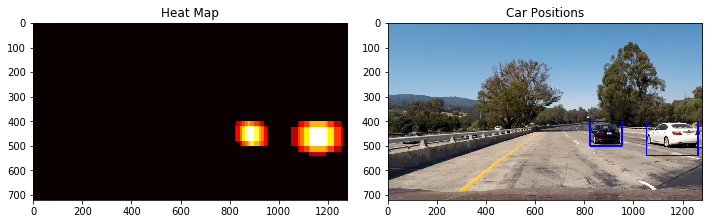

In [96]:
TEST_FITTED_BOXES = get_fitted_boxes(TEST_IMAGES[0], TEST_BOXES, vis=True)

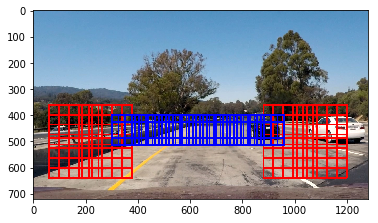

In [97]:
def get_next_windows(img, vis=False):
    img = TEST_IMAGES[0]
    left_windows = slide_window(
        img, xy_window=(128, 128), xy_overlap=(0.7, 0.7),
        x_start_stop=[60, 400], y_start_stop=[int(H/2), H-60]
    )
    right_windows = slide_window(
        img, xy_window=(128, 128), xy_overlap=(0.7, 0.7),
        x_start_stop=[W-400, W-60], y_start_stop=[int(H/2), H-60]
    )
    center_windows = slide_window(
        img, xy_window=(88, 88), xy_overlap=(0.7, 0.7),
        x_start_stop=[int(W/2)-340, int(W/2)+340], y_start_stop=[int(H/2)+40, int(H/2)+160]
    )
    if vis:
        sides = draw_boxes(img, left_windows + right_windows, color=(255, 0, 0), thick=6) 
        drawn = draw_boxes(sides, center_windows, color=(0, 0, 255), thick=6) 
        plt.imshow(drawn)
        
    return left_windows + right_windows + center_windows
    windows.extend(slide_window(
        img, xy_window=(128, 128), xy_overlap=(0.7, 0.7),
        x_start_stop=[int(W/2)-100, int(W/2)+100], y_start_stop=[int(H/2), H-60]
    ))
    if vis:
        window_img = draw_boxes(window_img, windows, color=(0, 0, 255), thick=6) 
        plt.imshow(window_img)

        
NEXT_WINDOWS = get_next_windows(TEST_IMAGES[0], vis=True)

In [ ]:
def get_nearby_windows(img, box, vis=False):
    w_size = 80

    x_start = box[0][0] - w_size
    if x_start < 0:
        x_start = 0
        
    x_stop = box[1][0] + w_size
    if x_stop > W:
        x_stop = W
    
    y_start = box[0][1] - w_size
    if y_start < 0:
        y_start = 0
        
    y_stop = box[1][1] + w_size
    if y_stop > H:
        y_stop = H
    
    big_windows = slide_window(
        img, x_start_stop=[x_start, x_stop], 
        y_start_stop=[y_start, y_stop], 
        xy_window=(124, 124), xy_overlap=(0.75, 0.75)
    )
    small_windows = slide_window(
        img, x_start_stop=[x_start, x_stop], 
        y_start_stop=[y_start, y_stop], 
        xy_window=(64, 64), xy_overlap=(0.75, 0.75)
    )
    if vis:
        window_img = draw_boxes(img, big_windows, color=(255, 0, 0), thick=4)
        window_img = draw_boxes(window_img, small_windows, color=(0, 0, 255), thick=2)
        plt.figure(figsize=(10,10))
        
        plt.imshow(window_img)
    return big_windows + small_windows


TEST_NEARBY_WINDOWS = get_nearby_windows(TEST_IMAGES[0], TEST_FITTED_BOXES[0], vis=True)

In [ ]:
def fit_boxes(img, windows, vis=True):
    boxes = search_windows(img, windows)
    fitted_boxes = get_fitted_boxes(img, boxes, vis=vis)


fit_boxes(TEST_IMAGES[5], TEST_NEARBY_WINDOWS, vis=True)

In [102]:
PREV_BOXES = []
PREV_FITTED_BOXES = []

def avg(a, b):
    windows = []
    windows.append((
        int((a[0][0] + b[0][0]) / 2),
        int((a[0][1] + b[0][1]) / 2),
    ))
    windows.append((
        int((a[1][0] + b[1][0]) / 2),
        int((a[1][1] + b[1][1]) / 2),
    ))
    return windows


def find_boxes(image):
    global PREV_FITTED_BOXES, PREV_BOXES
    img = np.copy(image)
    #if False and len(PREV_FITTED_BOXES) != 0:
        # print(PREV_BOXES)
    #    windows = get_next_windows(img)
    #    for box in PREV_FITTED_BOXES:
    #        windows += get_nearby_windows(img, box)

    #else:
        # print('b')
    #    windows = INITIAL_WINDOWS # get_initial_windows(img)

    # print(windows, len(PREV_BOXES))
    # print(windows)
    boxes = search_windows(img)
    fitted_boxes = get_fitted_boxes(img, boxes, 3)
    for box in fitted_boxes:
        # print(tuple(box), tuple(box[0]))
        cv2.rectangle(img, box[0], box[1], (0,0,255), 6)
    return img
    
    initial_boxes = search_windows(img)

    #if len(PREV_BOXES) >= 5:
    #    PREV_BOXES = PREV_BOXES[1:]

    #PREV_BOXES.append(boxes)
    # print(PREV_BOXES)
    #all_boxes = []
    # print(PREV_BOXES)
    #for box in PREV_BOXES:
    #    all_boxes.extend(box)
        
    # print(all_boxes, len(PREV_BOXES)+1)
    initial_fitted_boxes = get_fitted_boxes(img, initial_boxes, 2)
    
    windows = []
    for box in initial_fitted_boxes:
        window = get_nearby_windows(img, box)
        windows.extend(window)
        
    # print(windows)
    boxes = search_windows(img, windows)
    fitted_boxes = get_fitted_boxes(img, boxes, 6)
    #PREV_FITTED_BOXES = fitted_boxes
    # print(fitted_boxes)
    # PREV_BOXES = fitted_boxes # if len(PREV_BOXES) == 0 else avg(PREV_BOXES, fitted_boxes)
    # print(PREV_BOXES)
    for box in fitted_boxes:
        # print(tuple(box), tuple(box[0]))
        cv2.rectangle(img, box[0], box[1], (0,0,255), 6)
    return img

In [103]:
ar = [1,2,3]
ar = ar[1:]
ar.append(4)
print(ar)

[2, 3, 4]


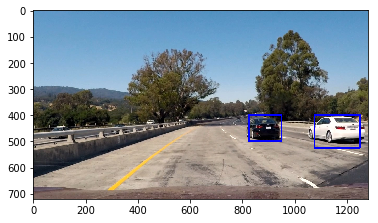

In [104]:
plt.imshow(find_boxes(TEST_IMAGES[0]))

In [105]:
from moviepy.editor import VideoFileClip


video_output = 'result.mp4'
initial = True
clip1 = VideoFileClip("project_video.mp4") # .subclip(38,43)
white_clip = clip1.fl_image(find_boxes) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [22:51<00:01,  1.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [ ]:
((np.array([(1,2),(3,4)]) + np.array([(5,6),(7,8)])) / 2).astype(int)
